In [1]:
import pandas as pd
import numpy as np
from numpy.random import randn

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_importance
from lightgbm import LGBMClassifier
import xgboost as xgb
from lightgbm import plot_importance

from scipy.stats import chi2_contingency
import scipy.stats as stats 
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import qqplot, add_constant
from statsmodels.api import Logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.proportion import proportions_ztest

import lightgbm as lgb
from subprocess import call
from IPython.display import Image
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from yellowbrick.cluster import SilhouetteVisualizer

import graphviz
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_samples, silhouette_score
from imblearn.over_sampling import SMOTE

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import warnings
warnings.filterwarnings('ignore')

matplotlib.rc('font', family = 'NanumBarunGothic')
matplotlib.rc('axes', unicode_minus = False)

In [2]:
df_merged = pd.read_csv("/home/piai/merged_with_2.csv", encoding = 'euc-kr')

In [3]:
df_Oxi = df_merged.iloc[:, :10]

In [4]:
df_Oxi

,Ox_Chamber,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,Lot_Num,Wafer_Num
0,2,dry,1214.33,O2,26.78,0.30,120.0,712.98,13,28
1,2,dry,977.98,O2,30.90,0.14,137.0,714.41,13,29
2,2,dry,1175.95,O2,31.11,0.25,116.0,710.27,13,30
3,2,dry,933.47,O2,31.20,0.29,143.0,710.62,13,31
4,2,wet,1140.60,H2O,31.38,0.20,76.0,711.70,13,32
...,...,...,...,...,...,...,...,...,...,...
15385,3,dry,1119.37,O2,27.37,0.13,50.0,711.92,13,23
15386,3,wet,1263.81,H2O,31.62,0.18,112.0,696.98,13,24
15387,3,wet,964.04,H2O,38.56,0.08,78.0,706.11,13,25
15388,3,dry,1058.80,O2,32.84,0.38,80.0,707.33,13,26


In [5]:
df_train,df_test=train_test_split(df_Oxi,test_size=0.3,random_state=1234)
print("train data size:{}".format(df_train.shape))
print("test data size:{}".format(df_test.shape))

train data size:(10773, 10)
test data size:(4617, 10)


In [6]:
# 데이터 준비 (가정: target은 레이블 열)
X_train = df_train.drop(columns=['thickness'])
y_train = df_train['thickness']
X_test = df_test.drop(columns=['thickness'])
y_test = df_test['thickness']

In [7]:
# 수치형과 범주형 변수 구분
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

# 수치형 변수 표준화
scaler = StandardScaler()
X_train_num = X_train[num_features]
X_test_num = X_test[num_features]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# 범주형 변수 원-핫 인코딩
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_cat = X_train[cat_features]
X_test_cat = X_test[cat_features]

X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

# 수치형 데이터와 범주형 데이터 결합
X_train_preprocessed = np.hstack((X_train_num_scaled, X_train_cat_encoded))
X_test_preprocessed = np.hstack((X_test_num_scaled, X_test_cat_encoded))

In [8]:
# LightGBM 회귀 모델 생성 및 학습
lgb_model = lgb.LGBMRegressor(random_state=1234)
lgb_model.fit(X_train_preprocessed, y_train)

# 테스트 데이터 예측_Chamber	type	Temp_OXid	Vapor	ppm	Pressure	Oxid_time	thickness	Lot_Num	Waf
y_pred_lgb = lgb_model.predict(X_test_preprocessed)

# 성능 평가
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

# 수정된 R² 스코어 계산
n = len(y_test)  # 샘플 수
p = X_test_preprocessed.shape[1]  # 피처 수
r2_adj_lgb = 1 - (1 - r2_lgb) * (n - 1) / (n - p - 1)

print(f"테스트 데이터 MSE (LightGBM 회귀): {mse_lgb:.4f}")
print(f"테스트 데이터 R² 스코어 (LightGBM 회귀): {r2_lgb:.4f}")
print(f"테스트 데이터 수정된 R² 스코어 (LightGBM 회귀): {r2_adj_lgb:.4f}")

테스트 데이터 MSE (LightGBM 회귀): 12.4439
테스트 데이터 R² 스코어 (LightGBM 회귀): 0.8037
테스트 데이터 수정된 R² 스코어 (LightGBM 회귀): 0.8032


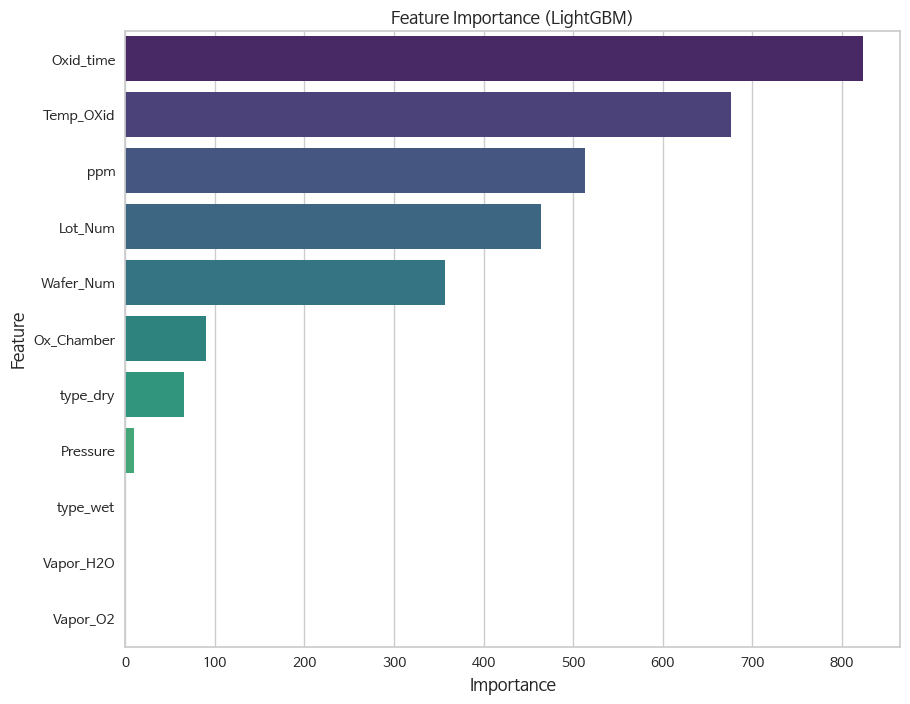

In [9]:
# 피처 중요도 추출
feature_importances = lgb_model.feature_importances_

# 피처 이름 생성 (수치형 및 범주형 변수의 인덱스)
num_feature_names = num_features
cat_feature_names = encoder.get_feature_names_out()
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# 피처 중요도와 피처 이름을 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# 중요도 기준으로 내림차순 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 수평 바플롯으로 피처 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, y='Feature', x='Importance', palette='viridis')
plt.title('Feature Importance (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [10]:
df_Oxi = df_merged.iloc[:, :10]
df_Oxi

# 1. 'Vapor_H2O' 열 제거
df_Oxi_cleaned = df_Oxi.drop(columns=['Vapor'])

# 2. 특징 변수와 타겟 변수 분리
X = df_Oxi_cleaned.drop(columns=['type'])
y = df_Oxi_cleaned['type']

# 3. 범주형 변수와 숫자형 변수 분리
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['number']).columns

# 4. 범주형 변수 인코딩 (OneHotEncoding)
ohe = OneHotEncoder(sparse=False, drop='first')
X_cat = ohe.fit_transform(X[categorical_features])
X_cat_df = pd.DataFrame(X_cat, columns=ohe.get_feature_names_out(categorical_features))

# 숫자형 변수 추출
X_num = X[numeric_features]

# 5. 데이터 합치기
X_encoded = pd.concat([X_num.reset_index(drop=True), X_cat_df.reset_index(drop=True)], axis=1)

# 6. 타겟 변수 인코딩 (문자열 -> 정수)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# 7. 데이터 분할: 70%는 학습용, 30%는 테스트용
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

# 8. 모델 학습
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# 9. 예측
y_pred = model.predict(X_test)

# 10. 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le_target.classes_))

# 11. 피처 중요도 추출
feature_importances = model.feature_importances_
feature_names = X_encoded.columns

# 중요도와 피처 이름을 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 피처 중요도 출력
print("\nFeature Importances:\n", importance_df)

# 결정 트리 모델 시각화
dot_data = export_graphviz(model, 
                           out_file=None, 
                           feature_names=X_encoded.columns,  
                           class_names=le_target.classes_,
                           filled=True, 
                           rounded=True,  
                           special_characters=True)  

# Graphviz를 사용하여 시각화
graph = graphviz.Source(dot_data)
graph.view("decision_tree")  # 결과를 보여줍니다

Accuracy: 0.9976175005414771
Classification Report:
               precision    recall  f1-score   support

         dry       1.00      1.00      1.00      2690
         wet       0.99      1.00      1.00      1927

    accuracy                           1.00      4617
   macro avg       1.00      1.00      1.00      4617
weighted avg       1.00      1.00      1.00      4617


Feature Importances:
       Feature  Importance
1   Temp_OXid    0.546019
5   thickness    0.116335
2         ppm    0.108463
4   Oxid_time    0.098620
6     Lot_Num    0.078248
7   Wafer_Num    0.049254
0  Ox_Chamber    0.002886
3    Pressure    0.000175


'decision_tree.pdf'

In [11]:
df_Pho1 = df_merged.iloc[:, 10:23]

In [12]:
df_Pho1

,photo_soft_Chamber,resist_target,N2_HMDS,pressure_HMDS,temp_HMDS,temp_HMDS_bake,time_HMDS_bake,spin1,spin2,spin3,photoresist_bake,temp_softbake,time_softbake
0,1,1.426,17.362,15.112,19.893,200.511,89.963,502.276,4017.015,4903.689,5.105,91.947,29.911
1,1,0.730,16.015,15.083,20.035,199.876,89.988,507.132,4073.049,4979.083,4.920,91.073,30.004
2,1,0.903,19.229,14.917,19.884,202.098,89.918,501.579,4085.002,5031.775,4.948,92.076,30.037
3,1,0.510,18.894,14.886,20.023,194.679,90.094,503.475,4045.281,4969.189,4.808,91.422,30.037
4,1,1.696,13.851,14.705,20.000,202.137,90.070,501.384,4010.123,5092.433,5.056,94.836,30.087
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15385,2,1.154,18.605,15.079,19.997,204.793,89.814,498.351,4082.535,5036.364,5.001,91.133,29.954
15386,2,0.876,16.181,14.991,20.029,197.465,90.008,502.040,4100.969,5013.599,4.854,94.065,29.972
15387,3,0.485,18.586,14.855,19.986,196.908,90.047,506.386,4074.398,4974.816,4.978,94.767,30.016
15388,3,1.672,14.112,14.876,19.785,196.579,90.096,494.780,4078.142,5011.773,5.133,91.877,29.963


In [13]:
df_train,df_test=train_test_split(df_Pho1,test_size=0.3,random_state=1234)
print("train data size:{}".format(df_train.shape))
print("test data size:{}".format(df_test.shape))

train data size:(10773, 13)
test data size:(4617, 13)


In [14]:
# 데이터 준비 (가정: target은 레이블 열)
X_train = df_train.drop(columns=['resist_target'])
y_train = df_train['resist_target']
X_test = df_test.drop(columns=['resist_target'])
y_test = df_test['resist_target']

In [15]:
# 수치형과 범주형 변수 구분
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

# 수치형 변수 표준화
scaler = StandardScaler()
X_train_num = X_train[num_features]
X_test_num = X_test[num_features]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# 범주형 변수 원-핫 인코딩
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_cat = X_train[cat_features]
X_test_cat = X_test[cat_features]

X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

# 수치형 데이터와 범주형 데이터 결합
X_train_preprocessed = np.hstack((X_train_num_scaled, X_train_cat_encoded))
X_test_preprocessed = np.hstack((X_test_num_scaled, X_test_cat_encoded))

In [16]:
# LightGBM 회귀 모델 생성 및 학습
lgb_model = lgb.LGBMRegressor(random_state=1234)
lgb_model.fit(X_train_preprocessed, y_train)

# 테스트 데이터 예측
y_pred_lgb = lgb_model.predict(X_test_preprocessed)

# 성능 평가
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

# 수정된 R² 스코어 계산
n = len(y_test)  # 샘플 수
p = X_test_preprocessed.shape[1]  # 피처 수
r2_adj_lgb = 1 - (1 - r2_lgb) * (n - 1) / (n - p - 1)

print(f"테스트 데이터 MSE (LightGBM 회귀): {mse_lgb:.4f}")
print(f"테스트 데이터 R² 스코어 (LightGBM 회귀): {r2_lgb:.4f}")
print(f"테스트 데이터 수정된 R² 스코어 (LightGBM 회귀): {r2_adj_lgb:.4f}")

테스트 데이터 MSE (LightGBM 회귀): 0.0725
테스트 데이터 R² 스코어 (LightGBM 회귀): 0.5961
테스트 데이터 수정된 R² 스코어 (LightGBM 회귀): 0.5951


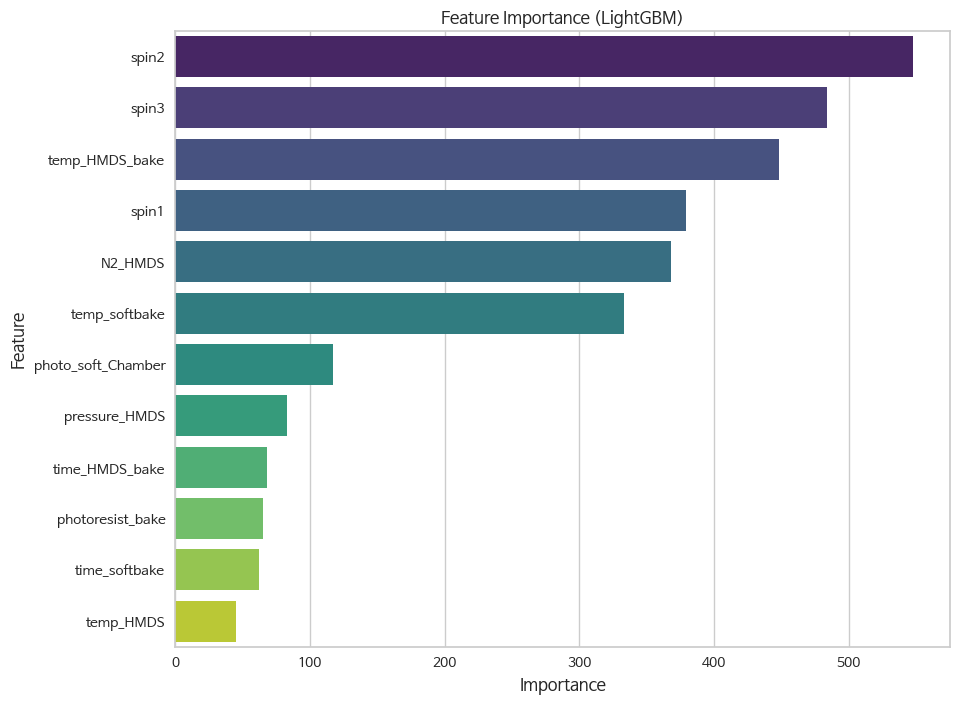

In [17]:
# 피처 중요도 추출
feature_importances = lgb_model.feature_importances_

# 피처 이름 생성 (수치형 및 범주형 변수의 인덱스)
num_feature_names = num_features
cat_feature_names = encoder.get_feature_names_out()
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# 피처 중요도와 피처 이름을 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# 중요도 기준으로 내림차순 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 수평 바플롯으로 피처 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, y='Feature', x='Importance', palette='viridis')
plt.title('Feature Importance (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [18]:
df_Pho2 = df_merged.iloc[:, 23:29]

In [19]:
df_Pho2

,lithography_Chamber,Line_CD,UV_type,Wavelength,Resolution,Energy_Exposure
0,1,41.548,I,365,505.405,109.653
1,1,53.649,H,405,541.691,104.946
2,1,47.647,I,365,532.233,106.563
3,1,33.040,G,436,537.622,108.696
4,1,57.411,H,405,522.135,109.944
...,...,...,...,...,...,...
15385,2,43.142,I,365,498.967,109.708
15386,3,39.551,I,365,519.122,108.390
15387,1,48.737,H,405,512.375,109.101
15388,2,50.806,I,365,522.391,110.378


In [20]:
df_train,df_test=train_test_split(df_Pho2,test_size=0.3,random_state=1234)
print("train data size:{}".format(df_train.shape))
print("test data size:{}".format(df_test.shape))

train data size:(10773, 6)
test data size:(4617, 6)


In [21]:
# 데이터 준비 (가정: target은 레이블 열)
X_train = df_train.drop(columns=['Line_CD'])
y_train = df_train['Line_CD']
X_test = df_test.drop(columns=['Line_CD'])
y_test = df_test['Line_CD']

In [22]:
# 수치형과 범주형 변수 구분
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

# 수치형 변수 표준화
scaler = StandardScaler()
X_train_num = X_train[num_features]
X_test_num = X_test[num_features]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# 범주형 변수 원-핫 인코딩
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_cat = X_train[cat_features]
X_test_cat = X_test[cat_features]

X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

# 수치형 데이터와 범주형 데이터 결합
X_train_preprocessed = np.hstack((X_train_num_scaled, X_train_cat_encoded))
X_test_preprocessed = np.hstack((X_test_num_scaled, X_test_cat_encoded))

In [23]:
# LightGBM 회귀 모델 생성 및 학습
lgb_model = lgb.LGBMRegressor(random_state=1234)
lgb_model.fit(X_train_preprocessed, y_train)

# 테스트 데이터 예측
y_pred_lgb = lgb_model.predict(X_test_preprocessed)

# 성능 평가
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

# 수정된 R² 스코어 계산
n = len(y_test)  # 샘플 수
p = X_test_preprocessed.shape[1]  # 피처 수
r2_adj_lgb = 1 - (1 - r2_lgb) * (n - 1) / (n - p - 1)

print(f"테스트 데이터 MSE (LightGBM 회귀): {mse_lgb:.4f}")
print(f"테스트 데이터 R² 스코어 (LightGBM 회귀): {r2_lgb:.4f}")
print(f"테스트 데이터 수정된 R² 스코어 (LightGBM 회귀): {r2_adj_lgb:.4f}")

테스트 데이터 MSE (LightGBM 회귀): 32.4437
테스트 데이터 R² 스코어 (LightGBM 회귀): 0.7720
테스트 데이터 수정된 R² 스코어 (LightGBM 회귀): 0.7716


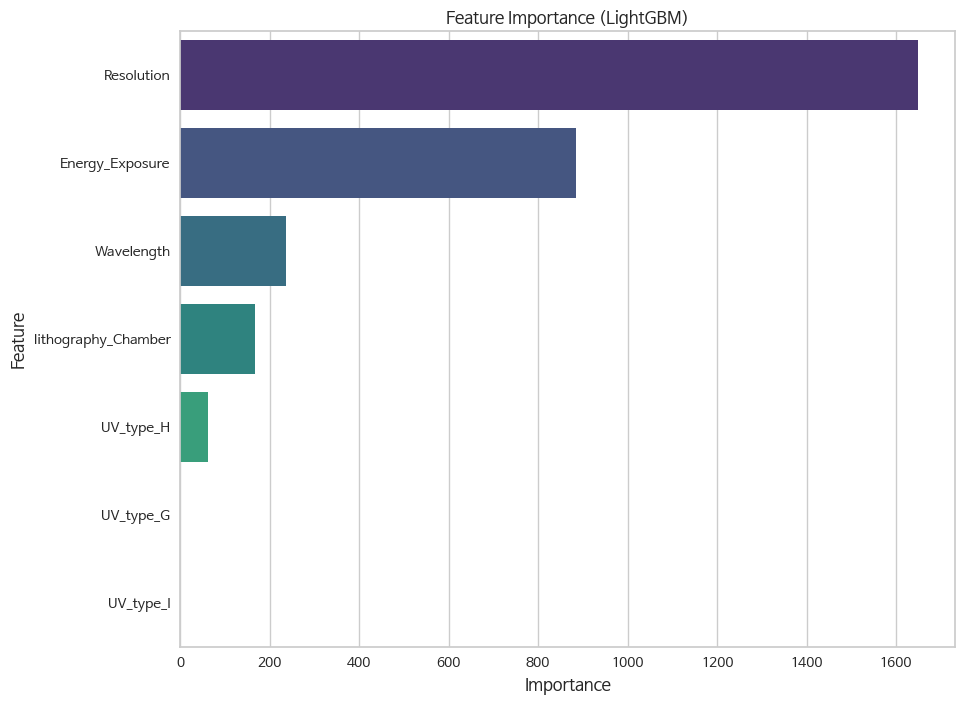

In [24]:
# 피처 중요도 추출
feature_importances = lgb_model.feature_importances_

# 피처 이름 생성 (수치형 및 범주형 변수의 인덱스)
num_feature_names = num_features
cat_feature_names = encoder.get_feature_names_out()
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# 피처 중요도와 피처 이름을 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# 중요도 기준으로 내림차순 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 수평 바플롯으로 피처 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, y='Feature', x='Importance', palette='viridis')
plt.title('Feature Importance (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()